## Firstly, training Endotypist<sup>XMBD</sup>

To create a case-control simulation experiment, we generated a scRNA-seq dataset from cell suspensions collected from the blood of healthy and bacteria-infected mice. The original data is available [here](https://doi.org/10.6084/m9.figshare.24152718) for academic use. 

In this example, we randomly assigned labels of either "case" or "control" to cells from healthy mice. Then, in the case group, we substituted all B cells with B cells sorted from mice that were infected.


In [1]:
%%bash

CUDA_VISIBLE_DEVICES=0  python Endotypist.py --sup-data-file "/home/zfeng/zfeng/Ni_huada/ni_huada_sim.csv" \
                        --sup-condition-file "/home/zfeng/zfeng/Ni_huada/ni_huada_sim_phenotype.txt" \
                        --sup-condition2-file "/home/zfeng/zfeng/Ni_huada/ni_huada_sim_uwv.txt" \
                        -lr 0.001 \
                        -n 300 \
                        -bs 500 \
                        --seed 0 \
                        --cuda \
                        -rt \
                        --layer-dropout-rate 0.2 \
                        -hl 500 \
                        -zd 100 \
                        -zi exact \
                        -likeli negbinomial \
                        --condition-type onehot \
                        --condition2-type onehot \
                        --save-model "ni_huada_sim.pth" 2>&1 | tee "ni_huada_sim.log"

1 epoch: avg losses 3062650.2054 0.0000 elapsed 3.4096 seconds
2 epoch: avg losses 1234675.8571 0.0000 elapsed 2.1169 seconds
3 epoch: avg losses 1056493.0536 0.0000 elapsed 2.1818 seconds
4 epoch: avg losses 997778.8482 0.0000 elapsed 2.0698 seconds
5 epoch: avg losses 947219.5714 0.0000 elapsed 2.1219 seconds
6 epoch: avg losses 909484.9643 0.0000 elapsed 2.0538 seconds
7 epoch: avg losses 873971.1875 0.0000 elapsed 2.0853 seconds
8 epoch: avg losses 842158.2143 0.0000 elapsed 2.1745 seconds
9 epoch: avg losses 816501.8839 0.0000 elapsed 2.0994 seconds
10 epoch: avg losses 798685.5357 0.0000 elapsed 2.1025 seconds
11 epoch: avg losses 786368.6429 0.0000 elapsed 2.0862 seconds
12 epoch: avg losses 778786.6786 0.0000 elapsed 2.1471 seconds
13 epoch: avg losses 771973.3661 0.0000 elapsed 2.0435 seconds
14 epoch: avg losses 768322.8393 0.0000 elapsed 2.0853 seconds
15 epoch: avg losses 763045.7321 0.0000 elapsed 2.1221 seconds
16 epoch: avg losses 756641.5536 0.0000 elapsed 2.1327 second

## Secondly, generating the cell expression after removing unwanted variations

In [2]:
import numpy as np
import pandas as pd

from Endotypist import Endotypist
from utils.scdata_cached import SingleCellCached

import torch
from torch.utils.data import DataLoader


from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks

%load_ext rpy2.ipython

In [3]:

ModelPath = 'ni_huada_sim.pth'
Omic1Path='/home/zfeng/zfeng/Ni_huada/ni_huada_sim.csv'
LabelPath=None
ConditionPath=None
ConditionPath2=None


In [4]:
# load model
model = torch.load(ModelPath)

batch_size = 10000

use_float64 = False
use_cuda = True
log_trans=True

In [5]:
# load data
data_cached = SingleCellCached(Omic1Path, LabelPath, ConditionPath, ConditionPath2, 'condition', log_trans=log_trans, use_cuda=False, use_float64 = use_float64)
data_loader = DataLoader(data_cached, batch_size = batch_size, shuffle = False)

In [6]:
# predict conditions
exprs = []

# use the appropriate data loader
for xs1,ys,ks,ks2 in data_loader:
    if use_cuda:
        xs1 = xs1.cuda()

    expr = model.generate_scaled_expression(xs1, mute_condition2=True, mute_noise=False)
    
    if use_cuda:
        expr = expr.cpu().detach().numpy()
    else:
        expr = expr.detach().numpy()

    exprs.append(expr)


exprs = np.concatenate(exprs, axis=0)


In [7]:
cells = pd.read_csv('/home/zfeng/zfeng/Ni_huada/ni_huada_sim_cell.txt', header=None)
genes = pd.read_csv('/home/zfeng/zfeng/Ni_huada/ni_huada_sim_gene.txt', header=None)


In [8]:
df = pd.DataFrame(exprs, index=cells.iloc[:,0].values)
meta = pd.read_csv('/home/zfeng/zfeng/Ni_huada/ni_huada_sim_meta.txt',index_col=0)
#dt.Frame(df).to_csv('/home/zfeng/zfeng/Ni_huada/ni_huada_sim_denoised_expression_bloodtype.txt')

## Thirdly, plotting with R

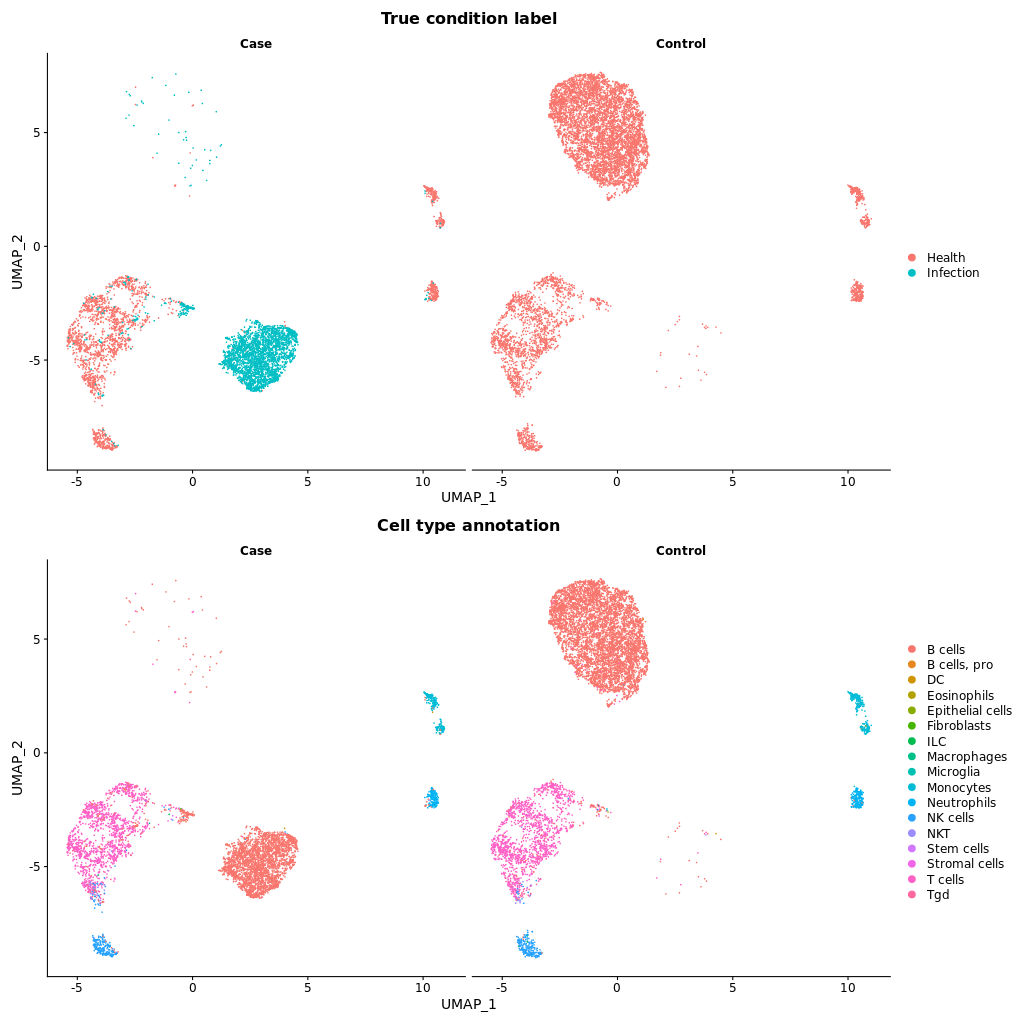

In [11]:
%%R -i df,meta -w 1024 -h 1024 -u px

library(Seurat)
library(dplyr)
library(uwot)
library(ggplot2)
library(patchwork)

data <- df
embed <- umap(data, n_threads = 40, pca=20)
colnames(embed) <- c('UMAP_1','UMAP_2')


recon <- CreateSeuratObject(data[,1:10] %>% t, meta.data = meta[rownames(data),])
recon[['umap']] <- CreateDimReducObject(embed %>% as.matrix(), key = 'UMAP_')
recon$Condition <- plyr::mapvalues(recon$Condition, from=c('Control'), to=c('Health'))

(DimPlot(recon, reduction = 'umap', group.by = 'Condition', split.by = 'Condition_v2', ncol = 2) +
    ggtitle('True condition label')) / 
(DimPlot(recon, reduction = 'umap', group.by = 'ImmGen_label', split.by = 'Condition_v2', ncol = 2) +
    ggtitle('Cell type annotation'))
